# Generating Samples

Author: Fred J. Hickernell + ChatGPT

This notebook provides examples of generating IID and low discrepancy samples from specific distributions and visualizing the results.

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/GeneratingRandomVectors.ipynb?flush_cache=true)

In [1]:
if "google.colab" in str(get_ipython()):
    print("⚡Note: Setup here can take a few minutes.")
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    %pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !git clone https://github.com/QMCSoftware/MATH565Fall2025.git
    %cd MATH565Fall2025/notebooks
    print("\n✅ Colab setup complete.")
    print("   For faster performance, please install the qmcpy environment locally.")

### Import needed packages and initialize some parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import qmcpy as qp
import time
from IPython.display import display, Markdown
import sys
from pathlib import Path
REPO_ROOT = Path.cwd().resolve().parent  # one level up from notebooks/
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
import nbviz as nb
nb.init(use_tex=True)                     # styling, Tol cycle, CSS, interactive plotting
colors = nb.TOL_BRIGHT                    # e.g., colors["cyan"]
TINY = nb.TINY

## IID Binomial samples
We start with the distribution that describes how many free throws we successfully make out of three attempts if we are a 60% free throw shooter and attempt 
- Generate $N$ samples with `scipy.stats.binom.rvs`
- Show **side-by-side** histograms for $N = 10$ and $N = 1000$
- Overlay the true PMF for comparison

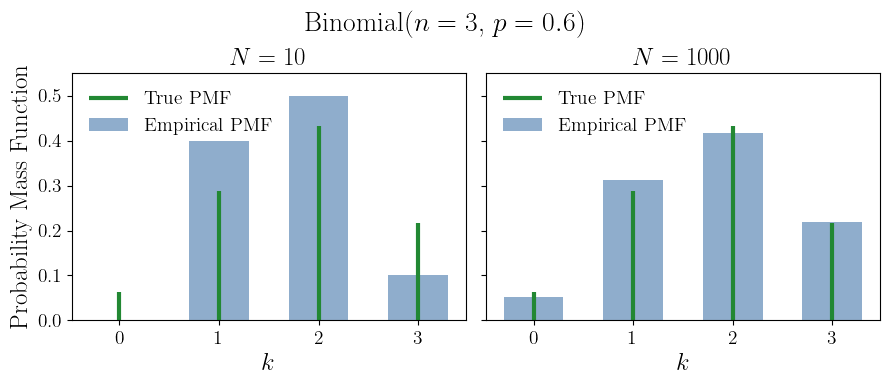

In [3]:
n, p = 3, 0.6  #the parameters of the Binomial distribution
free_throws_rv = sp.stats.binom(n=n, p=p)  #set up a Binomial random variable
k = np.arange(n+1)  #possible numbers of successes
pmf = free_throws_rv.pmf(k)  #evaluate the true (population) values of the probability mass function

N_vals = np.array([10, 1000])  #different sample sizes
num_N = len(N_vals)
bins=np.arange(-0.25, n+1.25, 0.5)
fig, axes = plt.subplots(1, num_N, figsize=(4.5*num_N, 4), sharey=True)

ymax = 1.2*pmf.max()
for ax, N in zip(axes, N_vals):
    samples = free_throws_rv.rvs(size=N)
    freq = np.bincount(samples, minlength=n+1) / N   # empirical PMF
    ax.bar(k, freq, width=0.6, color=colors["blue"], alpha=0.6, label="Empirical PMF")
    ax.vlines(k, 0, pmf, colors=colors["green"], lw=3, label="True PMF")
    ax.set_title(f"$N={N}$")
    ax.set_xlabel("$k$")
    ymax = max(ymax, 1.1 * freq.max())
    ax.legend(loc="upper left")

axes[0].set_ylim(0, ymax)
axes[0].set_ylabel("Probability Mass Function")
fig.suptitle(f"Binomial($n={n}$, $p={p}$)", y=0.95, fontsize = 20)
plt.tight_layout()

<div class="highlight-note">
Note:
<ul>
  <li>Every time you run the cell above you get a different answer</li>
  <li> Larger sample sizes tend to give better approximations to the true density</li>
</ul></div>

Next we plot the CDF and the quantile function for this random variable

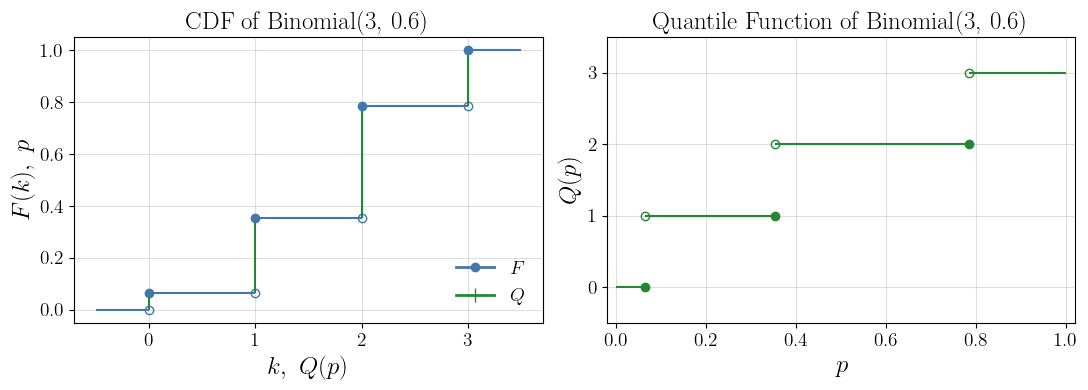

In [4]:
# probabilities for quantile function
cdf_vals = free_throws_rv.cdf(k)  #values of the cdf on the sample space

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
# --- Left: CDF ---
for i in range(n+2):
    if i == 0:
        x_start, y_val = -0.5, 0
    else:
        x_start, y_val = k[i-1], cdf_vals[i-1]
        axes[0].plot(x_start, y_val, "o", color=colors["blue"]) #closed circle at left
    if i < n + 1:
        x_end = k[i]
        axes[0].plot(x_end, y_val, "o", color=colors["blue"], fillstyle="none")  #open circle at right
        axes[0].vlines(x_end, y_val, cdf_vals[i], color=colors["green"])  #horizontal line for piecwise constant quantile function
    else:
        x_end = n + 0.5
    axes[0].hlines(y_val, x_start, x_end, color=colors["blue"])  #horizontal line for piecwise constant cdf
axes[0].set_title("CDF of Binomial(3, 0.6)")
axes[0].set_xlabel(r"$k,\ Q(p)$")
axes[0].set_ylabel(r"$F(k),\ p$")
axes[0].set_xticks(k)
axes[0].set_ylim(-0.05, 1.05)
axes[0].grid(alpha=0.4)
import matplotlib.lines as mlines
cdf_handle = mlines.Line2D([], [], color=colors["blue"], marker="o", markersize=6, lw=2, label=r"$F$")
q_handle   = mlines.Line2D([], [], color=colors["green"], marker="|", markersize=10, lw=2, label=r"$Q$")
axes[0].legend(handles=[cdf_handle, q_handle], loc="lower right", frameon=False)

# --- Right: Quantile Function ---
for i, ki in enumerate(k):
    y_val = ki
    if i == 0:
        p_start = 0.0
    else:
        p_start = cdf_vals[i-1]
        axes[1].plot(p_start, y_val, "o", color=colors["green"], fillstyle="none")  # open circle at left
    if i < n:
        p_end = cdf_vals[i]
        axes[1].plot(p_end, y_val, "o", color=colors["green"])  # closed circle at right
    else:
        p_end = 1.0
    axes[1].hlines(y_val, p_start, p_end, color=colors["green"])  # horizontal line for piecewise constant quantile

axes[1].set_title("Quantile Function of Binomial(3, 0.6)")
axes[1].set_xlabel("$p$")
axes[1].set_ylabel("$Q(p)$")
axes[1].set_xlim(-0.02, 1.02)
axes[1].set_ylim(-0.5, n+0.5)
axes[1].grid(alpha=0.4)
plt.tight_layout()

- The CDF is **right**-continuous and can be defined over $\mathbb{R}$
- The quantile function is **left**-continuous and might only be defined over $(0,1)$

## Zero-Inflated Exponential (ZIE)

This is the distribution where there is a positive probability of zero waiting time, but otherwise it looks like an exponential.  We will look at the following example:
- Probability of zero wait: $p = 0.2$
- Positive waits are Exponential with **mean** 10 minutes (scale = 10)
- Generate IID samples; show **empirical CDF** using `statsmodels` for N = 10 and N = 1000

We have already defined the distribution via a stats class.

Next we set up the parameters and plot the empirical CDF for this distribution

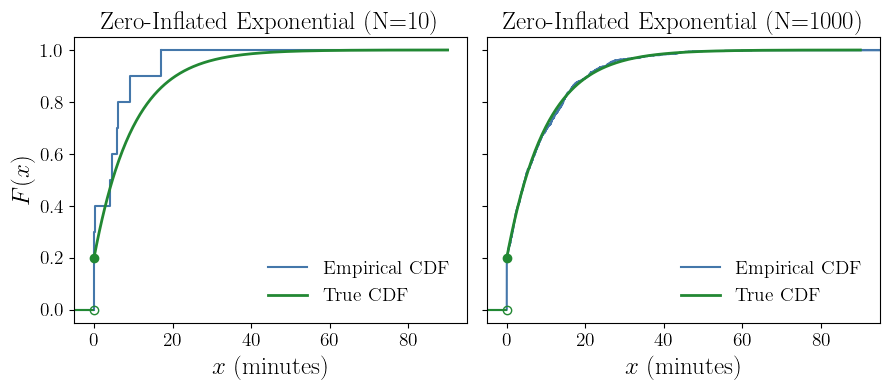

In [5]:
# --- ECDF plots with for-loops and statsmodels ---
from statsmodels.distributions.empirical_distribution import ECDF

# Parameters: p_zero = 0.2, positive mean = 10 minutes -> rate = 1/10
p_zero = 0.2        # P(X = 0) probability of a taxi already at the 'L' station
mean_pos = 10.0     # mean witing time in minutes if no taxi is there
from classlib.distributions import make_zie
zie = make_zie(p_zero=p_zero, mean_pos=mean_pos) #using the class defiend above

N_vals = [10, 1000]  #number of samples
m = len(N_vals)  #number of different N
xmax = 90  #maximum value of the random variable for plotting

fig, axes = plt.subplots(1, m, figsize=(4.5*m, 4), sharey=True)
axes = np.atleast_1d(axes)

for ax, N in zip(axes, N_vals):
    samples = zie.rvs(size=N)

    # statsmodels empirical cumulative distribution function
    ecdf = ECDF(samples)
    ax.step(ecdf.x, ecdf.y, where="post", label=f"Empirical CDF", color=colors["blue"])
    ax.hlines(ecdf.y[-1], ecdf.x[-1], xmax, colors=colors["blue"], linestyles="solid")
    ax.hlines(0, -5, 0, colors=colors["blue"], linestyles="solid")

    # --- True CDF ---
    # Force grid to include 0 and a tiny epsilon so that we can see the vertical line
    ax.hlines(0, -5, 0, colors=colors["green"], linestyles="solid")
    ax.plot(0, 0, "o", color=colors["green"], fillstyle="none")  #open circle
    ax.plot(0, p_zero, "o", color=colors["green"])  #closed circle
    grid = np.linspace(0, xmax, 400)
    ax.plot(grid, zie.cdf(grid), color=colors["green"], lw=2, label="True CDF")
    ax.set_xlim(-5, xmax+5)
    ax.set_title(f"Zero-Inflated Exponential (N={N})")
    ax.set_xlabel("$x$ (minutes)")
    ax.legend(loc="lower right")

axes[0].set_ylabel("$F(x)$")
plt.tight_layout()

<div class="highlight-note">
Note:
<ul>
  <li> Again, larger sample sizes give better approximations</li>
  <li> $F(x)$ is discontinuous at $x=0$</li>
</ul></div>

## Multivariate Gaussian/Normal Random Variable

This is example is constructing samples for the 2-vector $\vX = \mathcal{N}(\boldsymbol{\mu}, \mathsf{\Sigma})$.  This is done by finding $\mathsf{A}$ satifsfying $\mathsf{\Sigma} = \mathsf{A} \mathsf{A}^T$, and then letting $\vX_i = \boldsymbol{\mu} + \mathsf{A} \vU_i$, where $\vU_1, \vU_2, \ldots \overset{\text{IID}}{\sim} \mathcal{U}[0,1]^2$

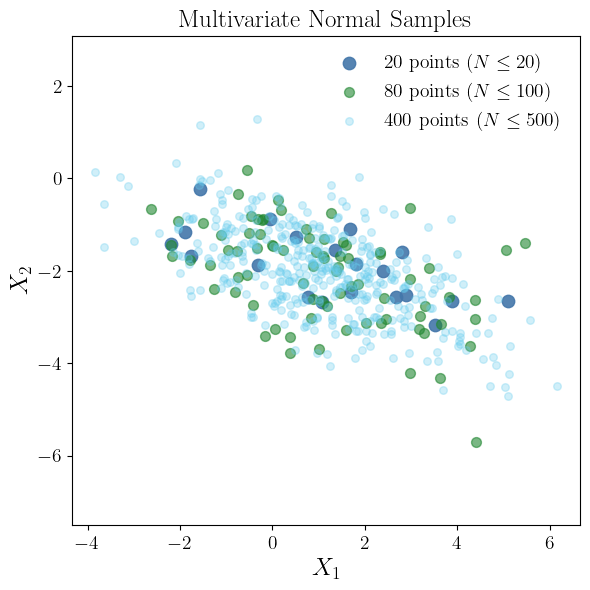

In [6]:
# Parameters
mu = np.array([1.0, -2.0])   #mean
Sigma = np.array([[3.0, -1.0],   #covariance matrix
                  [-1.0,  1.0]])
mvn = sp.stats.multivariate_normal(mean=mu, cov=Sigma)  #Set up multivariate normal
N_max = max(N_vals)
mvn_samples = mvn.rvs(size=N_max);

N_vals = [20, 100, 500]  #various sample sizes
colors_list = [colors["blue"], colors["green"], colors["cyan"]]
alpha_list = [0.9, 0.6, 0.3]
size_list = [80, 50, 30]

fig, ax = plt.subplots(figsize=(6, 6))
prevN = 0
for i, N in enumerate(N_vals):
    ax.scatter(mvn_samples[prevN:N, 0], mvn_samples[prevN:N, 1], s=size_list[i], alpha=alpha_list[i], \
               color=colors_list[i], label=f"{N - prevN} points ($N \\le {N}$)")
    prevN = N
ax.set_title("Multivariate Normal Samples")
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")
ax.axis("equal")
ax.legend(loc="upper right")
plt.tight_layout()

The decomposition of $\mathsf{\Sigma} = \mathsf{A} \mathsf{A}^T$ can be performed by the Cholesky decomposition or by eigenvectors and eigenvalues.

In [7]:
A_Chol = np.linalg.cholesky(Sigma)  #Cholesky decomposition of Sigma
print("A by Cholesky = \n", A_Chol)
print("\nA A^T =\n", A_Chol @ A_Chol.T, "\n which is close to Sigma\n")

eig_val, eig_vec = np.linalg.eigh(Sigma) #eigen-decomposition of sigma
A_eig = eig_vec @ np.diag(np.sqrt(eig_val))  
print("A by eigen-decomposition = \n", A_eig)
print("\nA A^T =\n", A_eig @ A_eig.T, "\n which is close to Sigma")

A by Cholesky = 
 [[ 1.73205081  0.        ]
 [-0.57735027  0.81649658]]

A A^T =
 [[ 3. -1.]
 [-1.  1.]] 
 which is close to Sigma

A by eigen-decomposition = 
 [[-0.29289322 -1.70710678]
 [-0.70710678  0.70710678]]

A A^T =
 [[ 3. -1.]
 [-1.  1.]] 
 which is close to Sigma


### Gaussian processes and Brownian Motions
Gaussian processes are random functions whose values at a finite number of points have a multivariate normal/Gaussian distribution.  They are often denoted $\cgp(\mu, K)$, where for any $g \sim \cgp(\mu, K)$
- $\mu$ is a function on the domain, $\Omega$ of these random functions, i.e., $\Ex[g(\vt)] = \mu(t)$ for all $\vt \in \Omega$, and
- $K$ is the covariance kernel defined on $\Omega \times \Omega$, i.e., $\Ex[\{g(\vt)-\mu(\vt)\}\{g(\vx)-\mu(\vx)\}] = K(\vt,\vx)$ for all $\vt, \vx \in \Omega$

Brownian motions, often denoted by $B$, (also called Wiener processes, denoted by $W$)  are an important special case of Gaussian processes:
$$
\Omega = [0, T], \qquad \mu(t) = 0, \qquad K(t,x) = \min(t,x)
$$
So if $0 \le t_1 \le t_2, \ldots \le t_d$ are specific times of interest, the multivariate normal random variable $\vX = (B(t_1), \ldots, B(t_d))$ has the distribtuion $\cn(\vzero, \mathsf{\Sigma})$, where 
$$
\Sigma = \begin{pmatrix}
t_1 & t_1 & t_1 & \cdots & t_1 \\
t_1 & t_2 & t_2 & \cdots & t_2 \\
t_1 & t_2 & t_3 & \cdots & t_3 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
t_1 & t_2 & t_3 & \cdots & t_d
\end{pmatrix} 
= \underbrace{
\begin{pmatrix}
\sqrt{t_1} & 0 & 0 & \cdots & 0 \\
\sqrt{t_1} & \sqrt{t_2 - t_1} & 0 & \cdots & 0 \\
\sqrt{t_1} & \sqrt{t_2 - t_1} & \sqrt{t_3-t_2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\sqrt{t_1} & \sqrt{t_2 - t_1} & \sqrt{t_3-t_2} & \cdots & \sqrt{t_d - t_{d-1}}
\end{pmatrix}}_{\large\mathsf{A}}
\underbrace{\begin{pmatrix}
\sqrt{t_1} & \sqrt{t_1} & \sqrt{t_1} & \cdots & \sqrt{t_1} \\
0 & \sqrt{t_2 - t_1} &\sqrt{t_2 - t_1} & \cdots & \sqrt{t_2 - t_1} \\
0 & 0 & \sqrt{t_3-t_2} & \cdots & \sqrt{t_3-t_2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \sqrt{t_d - t_{d-1}}
\end{pmatrix}}_{\large\mathsf{A}^\top}
$$
Below we plot some Brownian paths

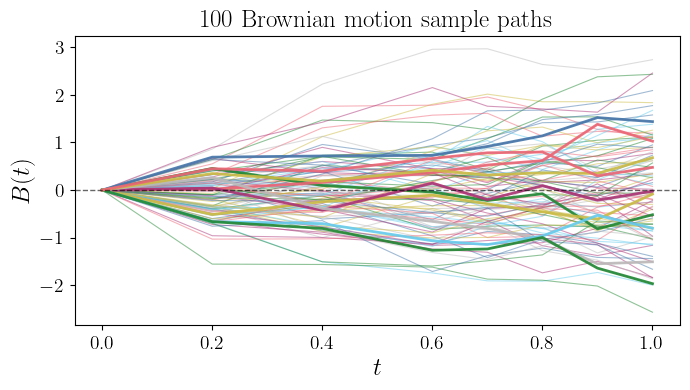

In [8]:
n_paths = 100  #number of paths
t_vec = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1])  #array of interesting times
mu = np.zeros_like(t_vec)  #mean of the Brownian motion
cov_mat = np.minimum.outer(t_vec,t_vec)  #and its covariance
BM = sp.stats.multivariate_normal(mean=mu, cov=cov_mat, allow_singular=True)  #Set up discretized Brownian motion
BM_paths = BM.rvs(size=n_paths)

# --- plot paths ---
plt.figure(figsize=(7, 4))
plt.plot(t_vec, BM_paths.T, lw=0.8, alpha=0.5)
plt.plot(t_vec, BM_paths.T[:,:10], lw=2, alpha=0.9)  #highlight a few
plt.axhline(0, lw=1, ls="--", c="k", alpha=0.6)
plt.xlabel(r"$t$")
plt.ylabel(r"$B(t)$")
plt.title(fr"{n_paths} Brownian motion sample paths")
plt.tight_layout()


### Modeling stock prices
Brownian motions are used in financial modeling.  If 
- $S_0$ is the initial price of a stock/asset
- $r$ is the interest rate
- $\sigma$ is the volatility
Then
$$
S(t) = S_0 \exp\bigl((r -\sigma^2/2)t  + \sigma B(t) \bigr)
$$
is a _geometric Brownian motion_ model of the stock price

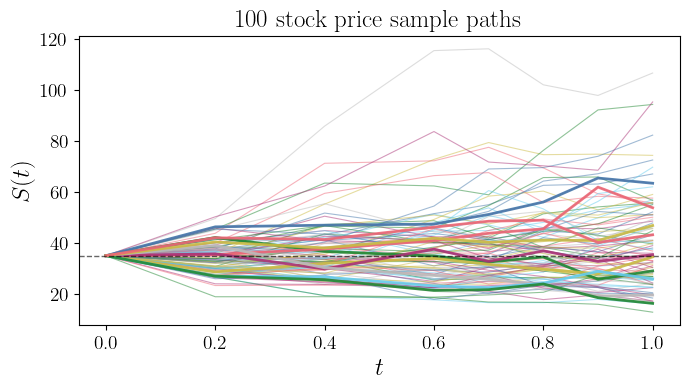

In [9]:
r = 0.1
sigma = 0.4
S_0 = 35
S_paths = S_0*np.exp((r - sigma**2/2)*t_vec[None,:] + sigma*BM_paths)
plt.figure(figsize=(7, 4))
plt.plot(t_vec, S_paths.T, lw=0.8, alpha=0.5)
plt.plot(t_vec, S_paths.T[:,:10], lw=2, alpha=0.9)  #highlight a few
plt.axhline(S_0, lw=1, ls="--", c="k", alpha=0.6)
plt.xlabel(r"$t$")
plt.ylabel(r"$S(t)$")
plt.title(fr"{n_paths} stock price sample paths")
plt.tight_layout()

As a sanity check, we compute the sample mean of these sample paths.  We know that $\Ex[S(t)] = S_0 \exp(rt)$

Absolute difference between true mean and sample mean =  [0.         1.63966026 0.05802321 0.04895957 0.07756529 0.27061403
 0.10729631 1.08133653]
RMSE of sample mean =  [0.         0.59794032 1.08057559 1.44321548 1.51328234 1.48671203
 1.58250701 1.79562159]


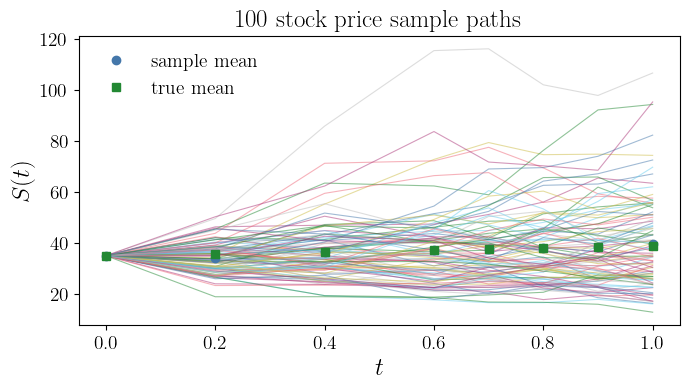

In [10]:
sample_mean_S = np.mean(S_paths, axis = 0)
true_mean_S = S_0*np.exp(r*t_vec)
err_mean_S = true_mean_S - sample_mean_S
plt.figure(figsize=(7, 4))
plt.plot(t_vec, S_paths.T, lw=0.8, alpha=0.5)
plt.plot(t_vec, sample_mean_S, 'o', color = colors["blue"], label='sample mean')
plt.plot(t_vec, true_mean_S, 's', color = colors["green"], label='true mean')
plt.xlabel(r"$t$")
plt.ylabel(r"$S(t)$")
plt.title(fr"{n_paths} stock price sample paths")
plt.legend()
plt.tight_layout()

print("Absolute difference between true mean and sample mean = ",np.abs(err_mean_S))
print("RMSE of sample mean = ", np.std(S_paths, axis = 0)/np.sqrt(n_paths))

### Option pricing
The payoff of an Asian Arithmetic Mean call option is
$$ 
\max\left(\frac 1T \int_0^T S(t) \mathrm{d} t - K, 0 \right) \exp(-rT)
$$ 
where $T$ is the time to maturity and $K$ is the strike price.  We can approximate this integral by the trapezoidal rule.

Below is a function that computes an discounted option payoff for an Asian arithmetic mean call.

In [11]:
def asian_arith_mean_call_payoff(
    X, #samples
    S0, #initial stock price
    r, #interest rate
    sigma, #volatility
    T, #time to maturity
    K, #strike price
) -> np.ndarray:
    """
    Discrete arithmetic-average Asian call payoff via Brownian-motion construction.
    X provides uniforms (QMC- or PRNG-based). Returns discounted payoffs per path.
    """
    (n_paths,d) = X.shape
    step = T/d
    t_vec = np.arange(1,d+1)*step  #array of interesting times
    cov_mat = np.minimum.outer(t_vec,t_vec)  #and its covariance
    eigvals, eigvecs = np.linalg.eigh(cov_mat)
    A  = eigvecs @ np.diag(np.sqrt(eigvals))
    BM_paths = sp.stats.norm.ppf(X) @ A.T  #discrete Brownian motion paths
    S_paths = S0*np.exp((r - sigma**2/2)*t_vec[None,:] + sigma*BM_paths)
    mean_price = (0.5*S0 + S_paths[:, :-1].sum(axis=1) + 0.5*S_paths[:, -1])*(step/T)  #trapezoidal rule
    payoff = np.maximum(mean_price - K,0)*np.exp(-r*T)
    return payoff

option_params = {  #parameters for the experiment below
    "S0": 100.0,
    "r": 0.02,
    "sigma": 0.5,
    "T": 1/4,
    "K": 100.0,
}

n_steps = 13 #number of time steps

Next we code a function that computes the expected value (mean) of the discounted payoff, which is the option price.

In [12]:
def plot_middle_half_sample_mean(
    sampler,
    f,
    n_max: int = 2**15,  
    n_rep: int = 21,  
    n_start: int = 9, 
    ax = None,
    label=None,
    color=None,
):
    """
    Plot the middle half (IQR band) of the sample mean of Y=f(X) vs number of samples n.

    Parameters
    ----------
    sampler : callable
        Function sampler(size, rng) -> array-like of X samples (size, ...).
        If your sampler ignores rng, that's fine.
    f : callable
        Function applied elementwise to X to produce Y.
    n_max : int, default = 1024   number must be a power of 2 for low discrepancy sampling
        Maximum number of samples per replication.
    n_rep : int, default 21
        Number of independent replications.
    n_start:  int, default = 10
        Where to start plotting
    ax : matplotlib.axes.Axes or None
        If None, create a new figure; otherwise plot into this Axes.
    label : str or None
        Label for the median curve (used in legend).
    color : str or None
        Optional color override for the curves/band.
    """
    n_max = int(n_max)
    n_rep = int(n_rep)
    cum_means = np.empty((n_rep, n_max), dtype=float) # Collect cumulative sample means for each replication (shape: n_rep × n_max)

    for r in range(n_rep):
        X = sampler(n_max)
        Y = f(X)
        Y = np.asarray(Y).reshape(-1)[:n_max] # Ensure 1-D along sample axis
        csum = np.cumsum(Y, dtype=float)  # Cumulative means: cumsum / arange(1..n_max)
        cum_means[r] = csum / np.arange(1, n_max + 1)

    # Percentile band across replications at each n
    q25 = np.percentile(cum_means, 25, axis=0)
    mean = np.percentile(cum_means, 50, axis=0)
    q75 = np.percentile(cum_means, 75, axis=0)
    std_err = np.std(cum_means, axis=0, ddof=1) / np.sqrt(n_rep)  # standard error
    z99 = 2.576  # 99% quantile of N(0,1)
    lower = mean - z99 * std_err
    upper = mean + z99 * std_err

    n = np.arange(1, n_max + 1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7.2, 4.5))
    ax.set_xscale("log")
    ax.fill_between(n[n_start:], q25[n_start:], q75[n_start:], alpha=0.2, color=color, label=None)
    ax.semilogx(n[n_start:], mean[n_start:], linewidth=2, label=label or "Mean", color=color)
    ax.semilogx(n[n_start:], lower[n_start:], '--', linewidth=1, color=color)
    ax.semilogx(n[n_start:], upper[n_start:], '--', linewidth=1, color=color)
    ax.set_xlabel("Number of samples $n$")
    ax.set_ylabel(r"Sample mean, $\;\hat{\mu}_n$")
    ax.set_title(rf"IQR (shaded) \& CI (dashed) for of sample mean vs. sample size")
    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.legend()
    plt.tight_layout();
    return ax

Finally we run this simulator for our Asian Arithmetic Mean example.

<div class="highlight-note">
For now, the best way we have to estimate the uncertainty in our sample mean is to do <strong>replications</strong>.
</div>

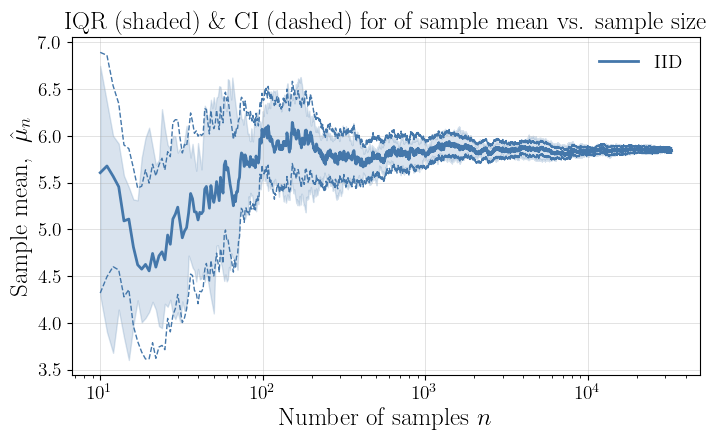

In [13]:
plot_middle_half_sample_mean(
    sampler= lambda n : np.random.random((n,n_steps)),
    f = lambda x : asian_arith_mean_call_payoff(x, **option_params),
    color=colors["blue"],
    label="IID"
);

## Low Discrepancy (LD) Sampling
We revisit LD sampling. These are sampling schemes where the vectors, $\vU_1, \vU_2, \ldots$ are NOT IID.  Here are three such schemes.  We will rely on the `qmcpy` library.

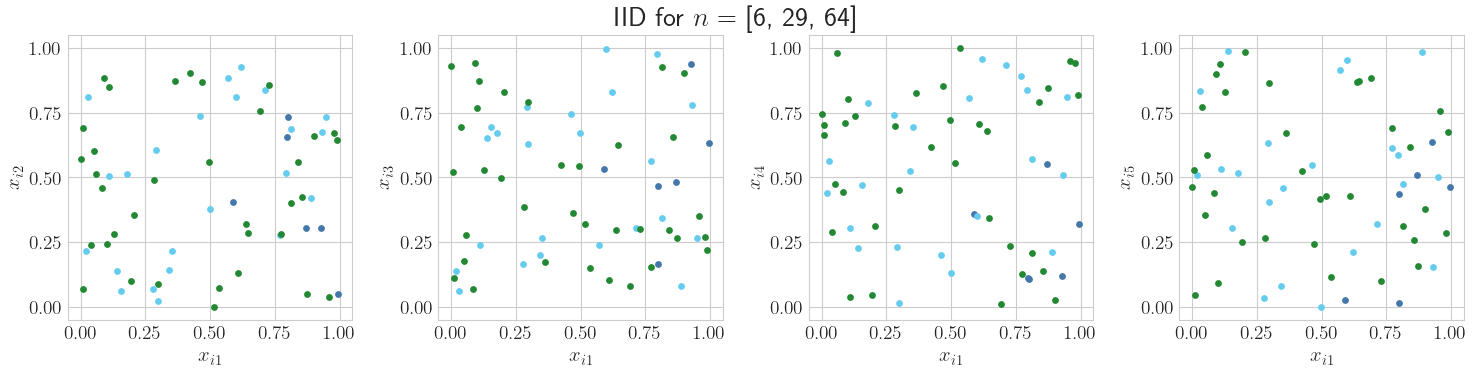

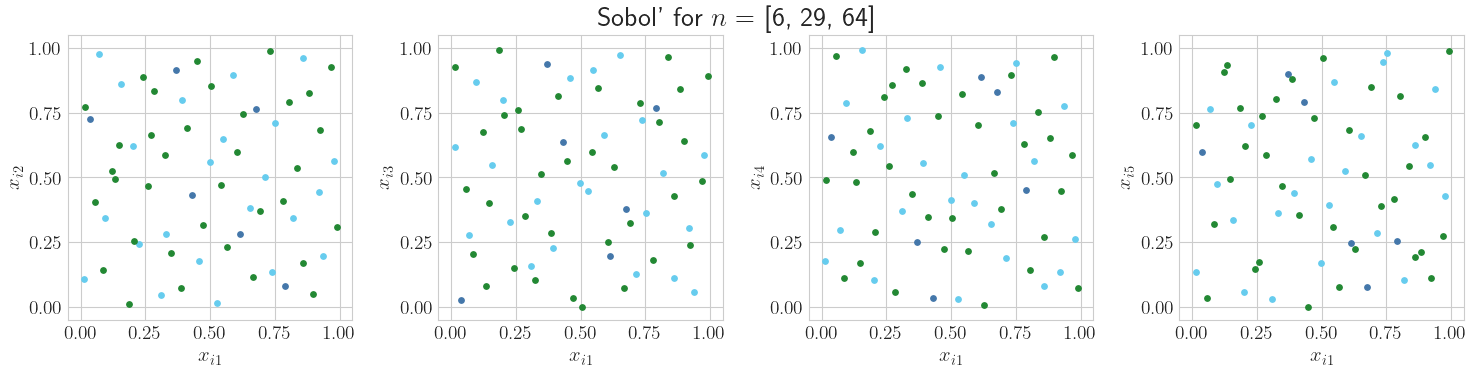

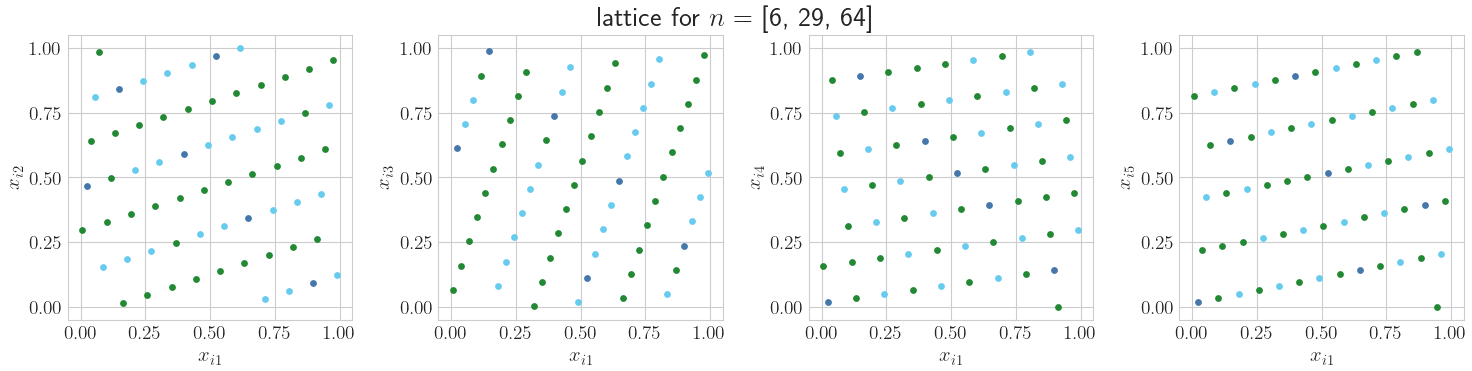

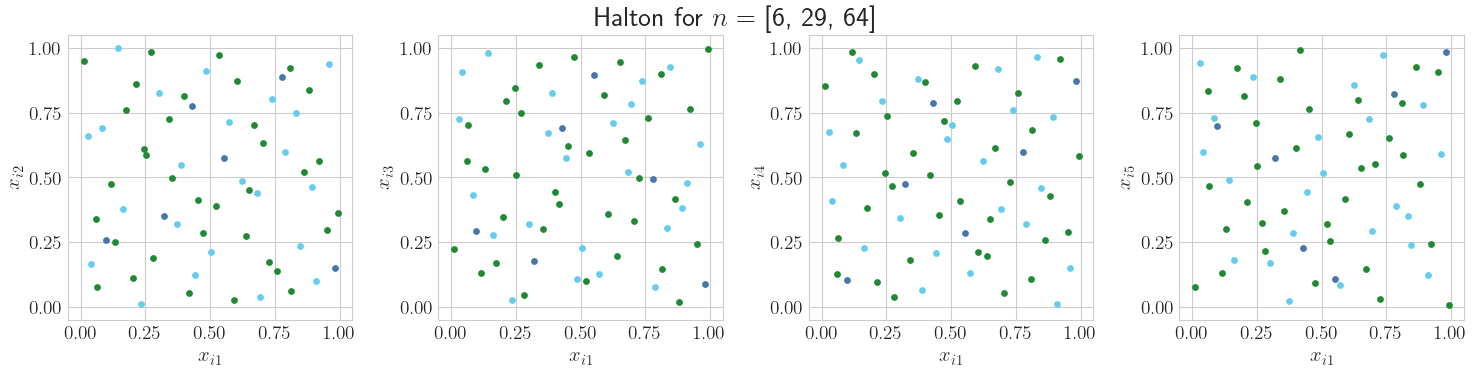

In [14]:
#----Some parameters-----#
d = 6  #the dimension used for these examples
n_list = [6, 29, 64]
ld_params = dict(
    n=n_list, #different values of the sample size
    d_horizontal=np.array([1]),  #coordinates for the rows
    d_vertical=np.arange(2,6),  #coordinates for the columns
    marker_size = 15,  #marker size
    figfac = 15,  #aspect ratio of matrix of figures
    where_title = 0.525,  #make the sup_title in the right place
    axis_pad = 0.05  #border around the figures
)
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), fig_title=f'IID for $n =$ {n_list}', **ld_params)
fig,ax = qp.plot_proj(qp.Sobol(d), fig_title=f"Sobol' for $n =$ {n_list}", **ld_params)
fig,ax = qp.plot_proj(qp.Lattice(d), fig_title=f'lattice for $n =$ {n_list}', **ld_params)
fig,ax = qp.plot_proj(qp.Halton(d), fig_title=f'Halton for $n =$ {n_list}', **ld_params)

<div class="highlight-note">
Note:
<ul>
  <li> The LD sampling schemes fill space better</li>
  <li> There are preferred sample sizes of $2^m$ for Sobol' and lattice</li>
</ul></div>

### Binomial distribution with LD sampling

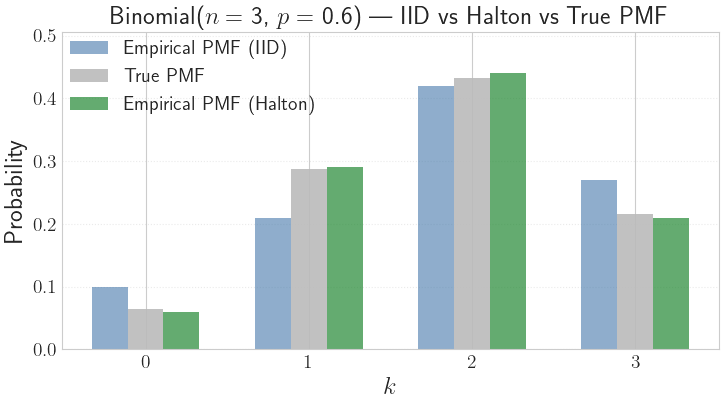

In [15]:
N = 100  #sample size
Halton_uniform_samples = qp.Halton(1).gen_samples(N).ravel()
Halton_binomial_samples = free_throws_rv.ppf(Halton_uniform_samples).astype(int) 
Halton_freq = np.bincount(Halton_binomial_samples, minlength=n+1) / N # empirical PMF
IID_samples = free_throws_rv.rvs(size=N)
IID_freq = np.bincount(IID_samples, minlength=n+1) / N # empirical PMF

# bar layout params
w = 0.22  # bar width
x = k.astype(float)

fig, ax = plt.subplots(figsize=(7.5, 4.3))
ax.bar(x - w, IID_freq, width=w, color=colors["blue"], alpha=0.6, label="Empirical PMF (IID)") # IID (left)
ax.bar(x, pmf, width=w, color=colors["gray"], alpha=0.9, label="True PMF") # True PMF
ax.bar(x + w, Halton_freq, width=w, color=colors["green"], alpha=0.7, label="Empirical PMF (Halton)")  # Halton (right)
ax.set_xticks(k)
ax.set_xlabel("$k$")
ax.set_ylabel("Probability")
ax.set_title(f"Binomial($n=$ {n}, $p=$ {p:.2g}) — IID vs Halton vs True PMF")
ax.set_ylim(0, 1.15*max(pmf.max(), Halton_freq.max(), IID_freq.max()))
ax.legend(loc="best")
ax.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout()


### Zero-Inflated Exponential with LD sampling

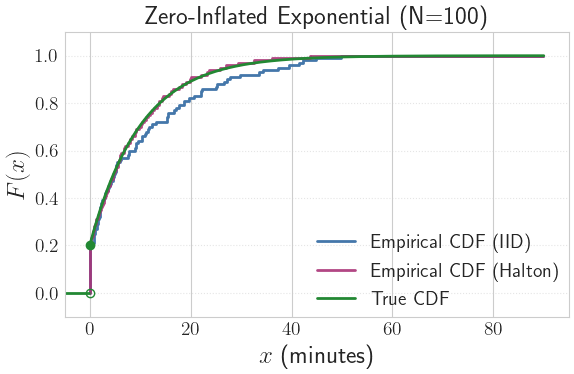

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

# --- IID samples + ECDF ---
samples_iid = zie.rvs(size=N)
ecdf_iid = ECDF(samples_iid)
ax.step(ecdf_iid.x, ecdf_iid.y, where="post",
        label="Empirical CDF (IID)", color=colors["blue"])
ax.hlines(ecdf_iid.y[-1], ecdf_iid.x[-1], xmax,
          colors=colors["blue"], linestyles="solid")

# --- Halton samples + ECDF ---
u = qp.Halton(1).gen_samples(N).ravel()
samples_halton = zie.ppf(u)
ecdf_halton = ECDF(samples_halton)
ax.step(ecdf_halton.x, ecdf_halton.y, where="post",
        label="Empirical CDF (Halton)", color=colors["purple"], alpha=0.9)
ax.hlines(ecdf_halton.y[-1], ecdf_halton.x[-1], xmax,
          colors=colors["purple"], linestyles="solid", alpha=0.9)

# --- True CDF (green) ---
ax.hlines(0, -5, 0, colors=colors["green"], linestyles="solid")
ax.plot(0, 0, "o", color=colors["green"], fillstyle="none")   # open circle at 0
ax.plot(0, p_zero, "o", color=colors["green"])                # closed circle at jump
grid = np.linspace(0, xmax, 400)
ax.plot(grid, zie.cdf(grid), color=colors["green"], lw=2, label="True CDF")

# --- Cosmetics ---
ax.set_xlim(-5, xmax+5)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel("$x$ (minutes)")
ax.set_ylabel("$F(x)$")
ax.set_title(f"Zero-Inflated Exponential (N={N})")
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()

### Asian Arithmetic Mean Call Option

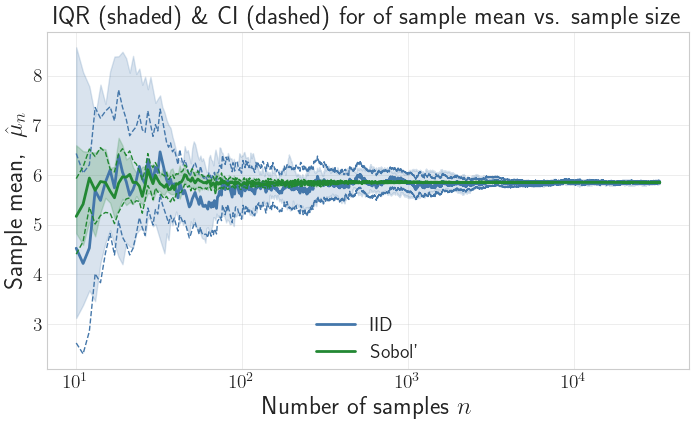

In [17]:
ax = plot_middle_half_sample_mean(
    sampler= lambda n : np.random.random((n,n_steps)),
    f = lambda x : asian_arith_mean_call_payoff(x, **option_params),
    color = colors["blue"],
    label = "IID"
)

plot_middle_half_sample_mean(
    sampler= lambda n : qp.Sobol(n_steps).gen_samples(n),
    f = lambda x : asian_arith_mean_call_payoff(x, **option_params),
    color = colors["green"],
    label = "Sobol'",
    ax = ax
);

<div class="highlight-note">
Note that by the eye-ball norm, LD sampling is better than IID
</div>